In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Here is [link](https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset) to dataset 

# Reading data


In [3]:
data = pd.read_csv('./data/House_Rent_Dataset.csv', parse_dates=True)
data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [4]:
data.shape

(4746, 12)

In [5]:
data.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [7]:
target_col = 'Rent'
num_cols = [col for col in data.columns if data[col].dtype == np.int64 and col != target_col]
cat_cols = [col for col in data.columns if col not in num_cols and col != target_col]
diverse_cat_cols = [col for col in cat_cols if len(data[col].unique()) > 10]
cat_cols = [col for col in cat_cols if col not in diverse_cat_cols]

We have a lot of unique values in Area Locality column.

# EDA

Lets look at distribution of numeric features

array([[<Axes: title={'center': 'BHK'}>,
        <Axes: title={'center': 'Rent'}>],
       [<Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'Bathroom'}>]], dtype=object)

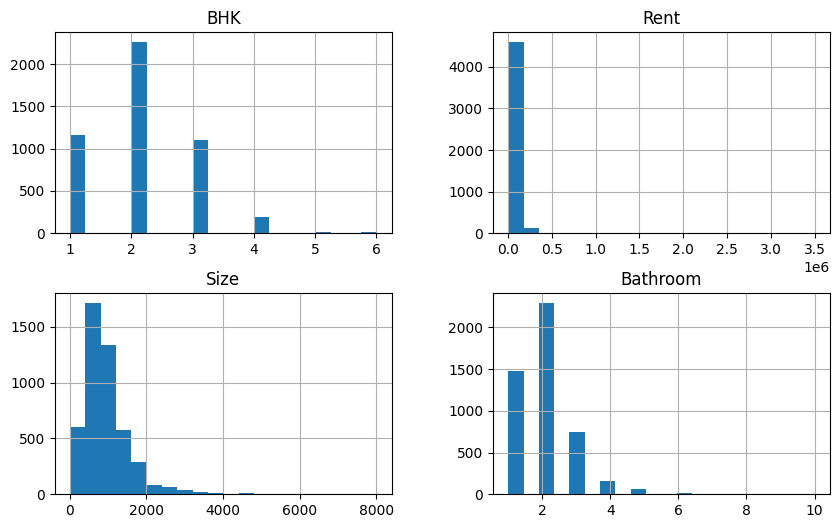

In [8]:
data.hist(figsize=(10, 6), bins=20)

We can see outliers in target variable distribution as well as in others.

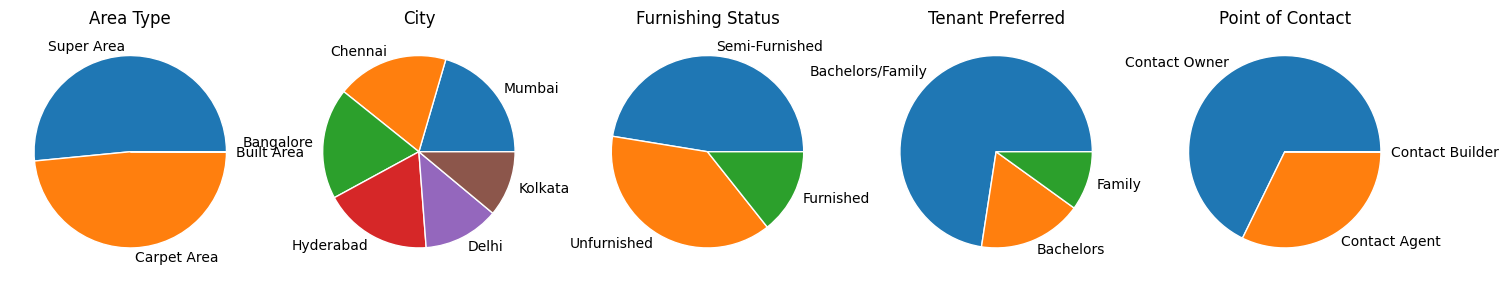

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(18, 8))
axes = axes.flatten()


for i, col in enumerate(cat_cols):
    axes[i].set_title(col)
    data_dist = data[col].value_counts()
    axes[i].pie(data_dist, 
                wedgeprops={"linewidth": 1, "edgecolor": "white"},
                labels = data_dist.index.values)

We can see that two of categorial features are quite balanced

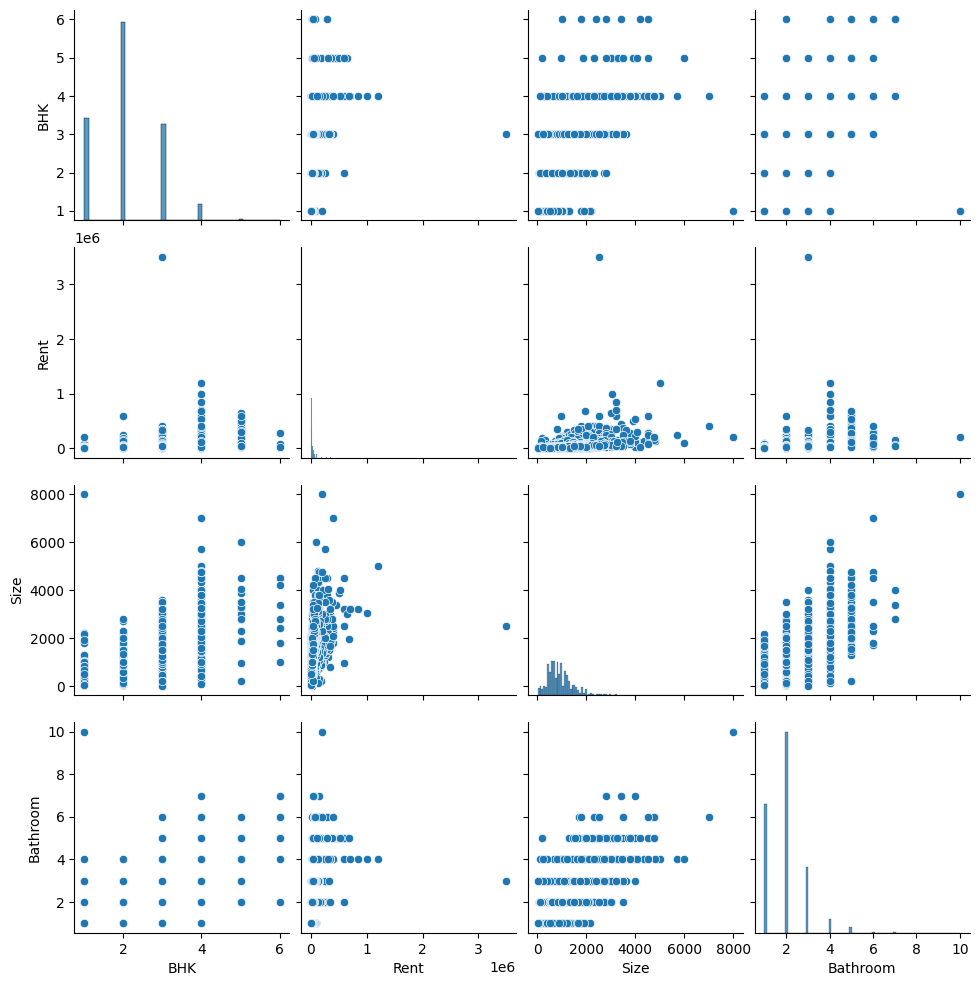

In [10]:
sns.pairplot(data)

We can see that other numeric features have some correlation with target variable.

<Axes: >

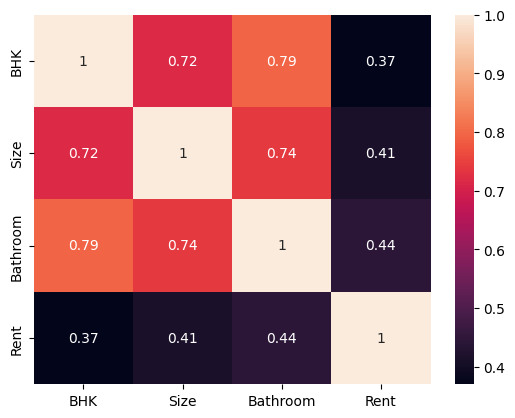

In [11]:
sns.heatmap(data[num_cols + ['Rent']].corr(), annot=True)

# Data Cleaning and Preprocessing

In [12]:
data.isna().sum().sum()

0

Surprisingly, we don't have any missing values. Lets handle outliers

array([[<Axes: title={'center': 'BHK'}>,
        <Axes: title={'center': 'Rent'}>],
       [<Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'Bathroom'}>]], dtype=object)

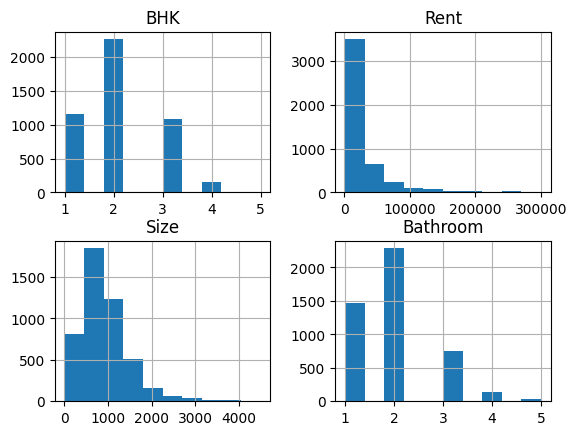

In [13]:
data = data.loc[(data['Rent'] <= 300000) & (data['Size'] <= 4500) & (data['BHK'] <= 5) & (data['Bathroom'] <= 5), :]
data.hist()

In [14]:
def floor_to_number(floor):
    num, den = floor.split('/')
    try:
        return int(num) / int(den)
    except:
        return 1 / int(den)
    

data['Floor'] = data['Floor'].str.replace(' out of ', '/')
data = data.loc[data['Floor'].str.contains('/'), :]
data['Floor'] = data['Floor'].apply(floor_to_number)
diverse_cat_cols.remove('Floor')
num_cols.append('Floor')

C:\Users\kamol\AppData\Local\Temp\ipykernel_23028\2395464240.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Floor'] = data['Floor'].str.replace(' out of ', '/')


I think features `Posted On` and `Area Locality` are irrelevant to our target, so I'll drop them.

In [15]:
data = data.drop(diverse_cat_cols, axis=1)

Now lets preprocess data by encoding categorial features and scaling numeric ones.

In [16]:
X, y = data.drop(target_col, axis=1), data[target_col]

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

cat_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='error'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols), ('num', num_transformer, num_cols)])
preprocessor.fit(X)

X_transformed = pd.DataFrame(preprocessor.transform(X), columns=preprocessor.get_feature_names_out())

# Model selection

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

In [19]:
pipeline = Pipeline([("regressor", RandomForestRegressor())])
param_grid = {"regressor": [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor()]}
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
)
grid_search.fit(X_transformed, y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor', RandomForestRegressor())]),
             param_grid={'regressor': [LinearRegression(),
                                       RandomForestRegressor(),
                                       GradientBoostingRegressor()]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [20]:
print(-grid_search.best_score_)
print(grid_search.best_estimator_)

10176.526627118188
Pipeline(steps=[('regressor', RandomForestRegressor())])


In [21]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(lgbm_model, X_transformed, y, scoring='neg_mean_absolute_error', 
                           cv=cv, n_jobs=-1, error_score='raise')
print(-np.mean(n_scores))

9352.457990571835


In [22]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
n_scores = cross_val_score(xgb_model, X_transformed, y, scoring='neg_mean_absolute_error',
                           cv=cv, n_jobs=-1, error_score='raise')
print(-np.mean(n_scores))

9865.208330745101


In [23]:
import pickle

scaler = StandardScaler().fit(X[num_cols])
X_scaled = pd.DataFrame(scaler.transform(X[num_cols]), columns=scaler.get_feature_names_out())
X_scaled = pd.concat([X[cat_cols].reset_index().drop('index', axis=1), X_scaled], axis=1)

with open('./models/scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

In [24]:
from catboost import cv, Pool, CatBoostRegressor

cv_data = Pool(data=X_scaled, label=y, cat_features=cat_cols)
params = {'iterations': 500, 'loss_function': 'MAE', 'verbose': False}
cv_results = cv(cv_data, params, fold_count=5, plot=False, return_models=True)

print(cv_results[0])

Training on fold [0/5]

bestTest = 8774.482352
bestIteration = 497

Training on fold [1/5]

bestTest = 8915.287417
bestIteration = 491

Training on fold [2/5]

bestTest = 9707.158402
bestIteration = 485

Training on fold [3/5]

bestTest = 8575.388424
bestIteration = 494

Training on fold [4/5]


We can see that CatBoostRegressor is the best choice with MAE score 8949.0

In [ ]:
model = cv_results[1][3]
model.save_model("./models/cb_regressor_model")